# ENSO Recharge Oscillator Practical: Simulations and Forecasting

This notebook serves as the Recharge Oscillator (RO) Practical for the [ENSO Winter School 2025](https://sites.google.com/hawaii.edu/enso-winter-school-2025/). It covers both theoretical and computational aspects of the RO framework, demonstrating its applications in ENSO simulations and forecasting.

**Instructors**
- **Sen Zhao** (<zhaos@hawaii.edu>)
- **Soong-Ki Kim** (<sskk503@yonsei.ac.kr>)
- **Jérôme Vialard** (<jerome.vialard@ird.fr>)

---

### Overview

In this notebook, we will demonstrate how to use the `XRO` framework for **Recharge-Oscillator (RO) model** fitting, simulations, and reforecasting.

***Extended Nonlinear Recharge Oscillator (XRO) framework***

The `XRO` framework was developed to investigate the role of climate mode interactions in ENSO dynamics and predictability ([Zhao et al. 2024](https://doi.org/10.1038/s41586-024-07534-6)). When other climate modes are not considered, it simplifies to the Recharge Oscillator (RO), making it well-suited for use in this practical context. We have designed `XRO` to be user-friendly, aiming to be a valuable tool not only for research but also for operational forecasting and as an educational resource in the classroom.

> Check out the updated version of XRO at https://github.com/senclimate/XRO


***Community Recharge Oscillator (CRO) model framework***

The `CRO` code package is an easy-to-use Python/MATLAB software for solving and fitting the ENSO RO model. The `CRO` code is currently under development and is planned for release in 2025. The distributed version for the ENSO Winter School 2025 is a light Python version that includes only the essential features. While we introduce the `CRO` framework in this practical, some of its functionalities are unavailable. Therefore, for consistency, we will primarily use the `XRO` framework.

For those interested in the `CRO` code, please refer to the Jupyter notebook:  
📂 *CRO_test/RO_Practical_with_CRO_Framework.ipynb*

Special thanks to **Bastien Pagli** for providing the original `CRO` code in Python.

---

### Run it at Google Colab
You can easily run this notebook on [Google Colab](https://colab.research.google.com/). 

Simply download [this notebook](RO_parctical_with_XRO_framework.ipynb) and upload it to Google Colab. 

Once uploaded, you can execute the notebook directly— all required data and Python libraries will be downloaded and installed automatically.


Load basic python libraries
Include libraries for both computing and visualization

In [1]:
import importlib.util
import subprocess
import sys
import warnings
import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
from climpred import HindcastEnsemble
from dateutil.relativedelta import *
from matplotlib.ticker import AutoMinorLocator
import warnings
import tqdm
import pathlib
import cmocean

## set plotting specs
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

## bump up DPI
import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 100

# Import necessary modules after ensuring files are available
from src.XRO import XRO, xcorr
from src.XRO_utils import (
    SkewAccessor,
    plot_above_below_shading,
    plot_fill_between,
    pmtm,
)

print("All required libraries are installed and imported successfully!")

All required libraries are installed and imported successfully!


## 1. Observed ENSO properties related to RO

Two indices are used to describe the oscillatory behaviour of ENSO. 
 - **$T$**: Sea surface temperature (SST) anomalies averaged over the Niño3.4 region 170°–120° W, 5° S–5° N
 - **$h$** Thermocline depth anomalies averaged over the equatorial Pacific 120° E–80° W, 5° S–5° N, that is, the WWV index (with a constant factor of the area it covers).


In [2]:
# load observed state vectors of XRO: which include ENSO, WWV, and other modes SST indices
# the order of variables is important, with first two must be ENSO SST and WWV;
obs_file = "../data/XRO_indices_oras5.nc"

obs_ds = xr.open_dataset(obs_file).sel(time=slice("1979-01", "2024-12"))
obs_RO_ds = obs_ds[["Nino34", "WWV"]]
print(obs_RO_ds)

<xarray.Dataset> Size: 11kB
Dimensions:  (time: 552)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2024-12-01
    month    (time) int32 2kB ...
Data variables:
    Nino34   (time) float32 2kB ...
    WWV      (time) float32 2kB ...


### 1.1 ENSO time series

Text(0.5, 1.0, 'ORAS5 Nino3.4 and WWV indices')

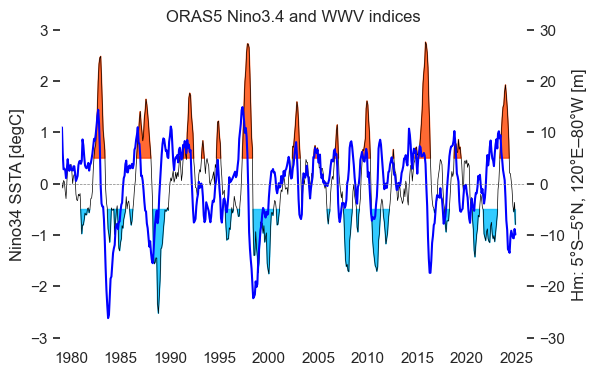

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

plot_above_below_shading(
    obs_RO_ds["Nino34"],
    xtime=obs_RO_ds.time,
    c="black",
    lw=0.5,
    above=0.5,
    above_c="orangered",
    below=-0.5,
    below_c="deepskyblue",
    ax=ax,
)
# obs_RO_ds['Nino34'].plot(ax=ax, c='black', )
ax.set_ylim([-3, 3])
ax.set_ylabel("Nino34 SSTA [degC]")

axR = ax.twinx()
obs_RO_ds["WWV"].plot(ax=axR, c="blue", lw=1.5)
axR.set_ylim([-30, 30])
axR.axhline(0, ls="--", c="gray", lw=0.5)

ax.set_xlim([datetime.datetime(1979, 1, 1), datetime.datetime(2026, 1, 1)])
ax.set_title("ORAS5 Nino3.4 and WWV indices")

## Look at parameter variation over time

#### Fit model to 20-yr rolling windows

In [4]:
## Get number of timesteps in data
n = len(obs_RO_ds.time)

## specify number of samples to use in each window
window_size = 240  # units: months

## empty list to hold results and dates
params_by_year = []
start_dates = []

## loop through rolling windows
with warnings.catch_warnings(action="ignore"):
    for i in np.arange(0, n - 12, 12):

        ## make sure there's enough samples for robust estimate
        if (n - i) > (0.7 * window_size):

            ## get subset of data for fitting model
            data_subset = obs_RO_ds.isel(time=slice(i, i + window_size))

            ## Get start date for subset
            start_dates.append(data_subset.time.isel(time=0))

            ## initialize model
            model = XRO(ncycle=12, ac_order=1, is_forward=True)

            ## fit matrix and get parameters
            fit_LRO = model.fit_matrix(data_subset, maskNT=[], maskNH=[])
            params_by_year.append(model.get_RO_parameters(fit_LRO))

## convert from list to xarray
start_dates = xr.concat(start_dates, dim="time")
params_by_year = xr.concat(params_by_year, dim=start_dates)

#### Plot change over time in annual-mean $R$ and seasonal cycle

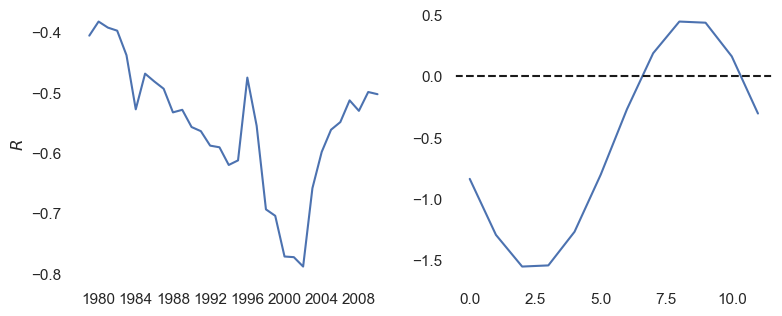

In [5]:
## plot annual mean growth rate
fig, axs = plt.subplots(1, 2, figsize=(9, 3.5))
axs[0].plot(params_by_year.time, params_by_year["BJ_ac"].mean("cycle"))
axs[0].set_ylabel(r"$R$")

## plot mean annual cycle
axs[1].plot(params_by_year["BJ_ac"].mean("time"))
axs[1].axhline(0, c="k", ls="--")

plt.show()

## fit to MPI data

### Load in MPI data

In [6]:
load_fp = pathlib.Path("/Users/theo/research/enso2025_xro/data/mpi_Th/Th.nc")
Th = xr.open_dataset(load_fp)

### Function to fit to ensemble chunk

In [7]:
def get_ensemble_params(data, T_var="T_3", h_var="h_w", verbose=False):
    """get RO params for each ensemble member"""

    ## empty list to hold params
    params = []

    ## Loop thru ensemble members
    for m in tqdm.tqdm(data.member, disable=not (verbose)):

        ## initialize model
        model = XRO(ncycle=12, ac_order=1, is_forward=True)

        ## select ensemble member and variables
        data_subset = data[[T_var, h_var]].sel(member=m)

        ## fit model
        with warnings.catch_warnings(action="ignore"):
            fit = model.fit_matrix(data_subset, maskNT=[], maskNH=[])

        ## append to list of parameters
        params.append(model.get_RO_parameters(fit))

    return xr.concat(params, dim=data.member)


def get_ensemble_params_over_time(
    data, T_var="T_3", h_var="h_w", window_size=360, step_size=60
):
    """Get RO params for each ensemble member as a function of time.
    Args:
        window_size: size of sliding window (units: months)
        step_size: how many months to slide the window between each calculation
    """

    ## Get number of timesteps in data
    n = len(data.time)

    ## empty list to hold results and dates
    params_by_year = []
    start_dates = []

    ## loop through rolling windows
    for i in tqdm.tqdm(np.arange(0, n - step_size, step_size)):

        ## make sure there's enough samples for robust estimate
        if (n - i) > (0.7 * window_size):

            ## get subset of data for fitting model
            data_subset = data.isel(time=slice(i, i + window_size))

            ## Get start date for subset
            start_dates.append(data_subset.time.isel(time=0))

            ## get parameter fit
            params_by_year.append(
                get_ensemble_params(
                    data_subset, T_var=T_var, h_var=h_var, verbose=False
                )
            )

    ## convert from list to xarray
    start_dates = xr.concat(start_dates, dim="time")
    params_by_year = xr.concat(params_by_year, dim=start_dates)

    return params_by_year

### Compute over time

In [8]:
## specify save filepath
save_fp = pathlib.Path("/Users/theo/research/enso2025_xro/results/params.nc")

## Load parameters if already computed
if save_fp.is_file():
    params = xr.open_dataset(save_fp)

else:
    ## compute params
    params = get_ensemble_params_over_time(Th, window_size=360, step_size=60)

    ## save to file
    params.to_netcdf(save_fp)

### Plot diagnostics

#### Ensemble-mean growth rate as a function of seasonal cycle and time

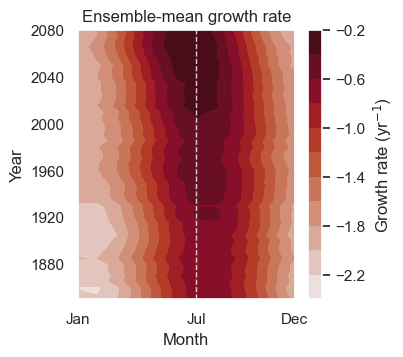

In [9]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

## plot data
cp = ax.contourf(
    params.cycle, params.time, params["BJ_ac"].mean("member"), cmap="cmo.amp", levels=10
)

## set ticks and add guideline
ax.set_xticks([1, 7, 12], labels=["Jan", "Jul", "Dec"])
ax.axvline(7, c="w", ls="--", lw=1, alpha=0.8)

## add colorbar
cb = fig.colorbar(cp, label=r"Growth rate (yr$^{-1}$)")

## label
ax.set_title("Ensemble-mean growth rate")
ax.set_xlabel("Month")
ax.set_ylabel("Year")

plt.show()

#### Plot annual max growth rate

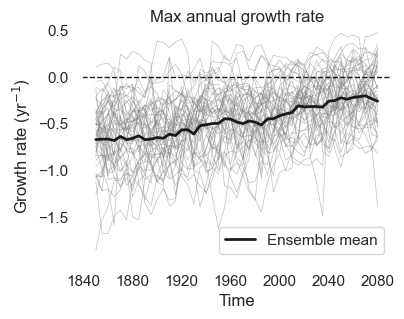

In [10]:
fig, ax = plt.subplots(figsize=(4, 3))

## plot ensemble members
for i, m in enumerate(params.member.values):

    label = "Ensemble members" if (i == 50) else None

    ax.plot(
        params.time,
        params["BJ_ac"].sel(member=m).max("cycle"),
        c="gray",
        alpha=0.5,
        lw=0.5,
    )

## plot ensemble mean
ax.plot(
    params.time,
    params["BJ_ac"].mean("member").max("cycle"),
    c="k",
    lw=2,
    label="Ensemble mean",
)

## add labels and set plot style
ax.axhline(0, c="k", ls="--", lw=1)
ax.set_ylim([None, 0.5])
ax.set_xlabel("Time")
ax.set_ylabel(r"Growth rate (yr$^{-1}$)")
ax.set_title("Max annual growth rate")
ax.legend()

plt.show()

## Compare stats b/n RO and MPI (To-do)

### Stochastic integration

In [ ]:
## Fit model on first 30 years of dataset and last 30 years of dataset


def get_RO_ensemble(data, T_var="T_3", h_var="h_w", verbose=False):
    """get RO params for each ensemble member"""

    ## initialize model
    model = XRO(ncycle=12, ac_order=1, is_forward=True)

    ## empty list to hold model fits
    fits = []

    ## Loop thru ensemble members
    for m in tqdm.tqdm(data.member, disable=not (verbose)):

        ## select ensemble member and variables
        data_subset = data[[T_var, h_var]].sel(member=m)

        ## fit model
        with warnings.catch_warnings(action="ignore"):
            fits.append(model.fit_matrix(data_subset, maskNT=[], maskNH=[]))

    return model, xr.concat(fits, dim=data.member)

### Get ensemble of RO models for early/late period

In [ ]:
## get data for early/late period
Th_early = Th.isel(time=slice(None, 600))
Th_late = Th.isel(time=slice(-600, None))

model, RO_params_early = get_RO_ensemble(Th_early, verbose=True)
_, RO_params_late = get_RO_ensemble(Th_late, verbose=True)

### Get ensemble of RO simulations

In [ ]:
seed = 1000
RO_ensemble_early = model.simulate(
    fit_ds=RO_params_early.mean("member"),
    X0_ds=Th[["T_3", "h_w"]].isel(time=0, member=0),
    nyear=50,
    ncopy=100,
    noise_type="red",
    seed=seed,
    is_xi_stdac=False,
    xi_B=0.0,
    is_heaviside=True,
)

#### Seasonal synchronization

In [ ]:
## specify which variable to plot
var_name = "T_3"

## compute std for each dataset
RO_std = RO_ensemble_early.groupby("time.month").std()
mpi_std = Th_early.groupby("time.month").std()

fig, ax = plt.subplots(figsize=(4, 3))

ax.plot(mpi_std.month, mpi_std[var_name].mean("member"))
ax.plot(
    mpi_std.month,
    mpi_std[var_name].mean("member") + mpi_std[var_name].std("member"),
    c="k",
)
ax.plot(mpi_std.month, RO_std[var_name].mean("member"))
ax.plot(mpi_std.month, RO_std[var_name].mean("member") + RO_std[var_name].std("member"))